# Evaluación de la red cuántica construida

_Maialen Espí Landa - 11.08.2024_

In [3]:
from sklearn.model_selection import train_test_split
from qnn import QNN

import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import pandas as pd
import numpy as np
import torch
import time

### Preparación de datos

In [6]:
def f(n_points = 1000):
    X = np.linspace(0, 1, n_points)
    y = (X ** 2) * np.sin(5 * np.pi * X)
    y = (y - y.min(axis = 0)) / (y.max(axis = 0) - y.min(axis = 0))
    return X, y

X, y = f()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
sorted_indices = np.argsort(X_test.flatten())
X_test, y_test = X_test[sorted_indices], y_test[sorted_indices]

print(f"Tamaño de set de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño de set de test: {X_test.shape[0]}")

Tamaño de set de entrenamiento: 800
Tamaño de set de test: 200


### Entrenamiento de redes (con diferente número de capas / puertas)

In [7]:
min_layers = 1
max_layers = 9
step_layers = 2
cut_off = 10
results = {}

for l in range(min_layers, max_layers, step_layers):
    print(f"Número de capas/puertas: {l}")
    start_time = time.time()
    net = QNN(n_layers = l, cut_off = cut_off)
    train_losses, val_losses = net.train(X_train, y_train, lr = 0.05, epochs = 100)
    y_predicted = net(torch.tensor(X_test, dtype = torch.float32)).detach().numpy()
    print(f"Loss: {val_losses[-1]}\n")
    end_time = time.time()
    results[l] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "y_predicted": y_predicted,
        "train_time": end_time - start_time
    }

# GUARDAR RESULTADOS
with open("results.pkl", "wb") as f:
    pkl.dump(results, f)

Número de capas/puertas: 1


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Loss: 0.05903004854917526

Número de capas/puertas: 3


100%|██████████| 100/100 [02:41<00:00,  1.61s/it]


Loss: 0.017047042027115822

Número de capas/puertas: 5


100%|██████████| 100/100 [04:13<00:00,  2.54s/it]


Loss: 0.0012928901705890894

Número de capas/puertas: 7


100%|██████████| 100/100 [11:06<00:00,  6.67s/it]

Loss: 4.5727752876700833e-05



### Representación de los resultados

#### Curva de evaluación

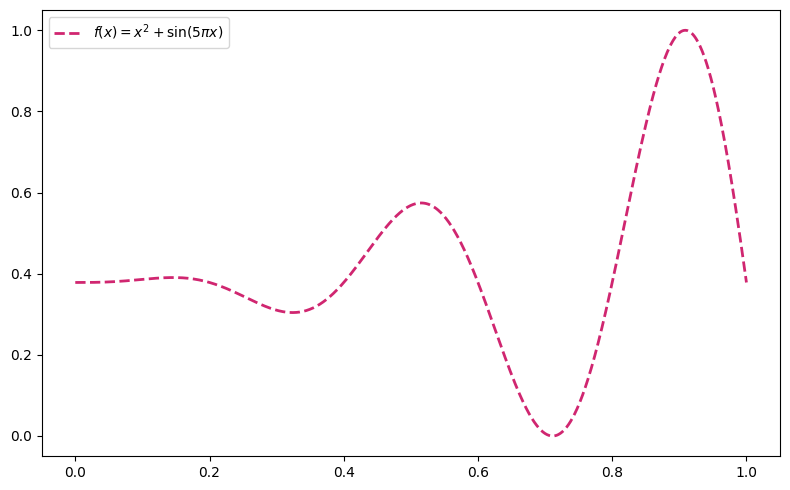

In [33]:
plt.figure(figsize = (8, 5))
plt.plot(X, y, color = "#d02670", linewidth = 2, linestyle = '--', label = "$f(x) = x^2 + \sin(5 \pi x)$")
plt.legend()
plt.tight_layout()
plt.savefig("images/eval-curve.jpg", dpi = 800)
plt.show()

#### Aproximación de la curva

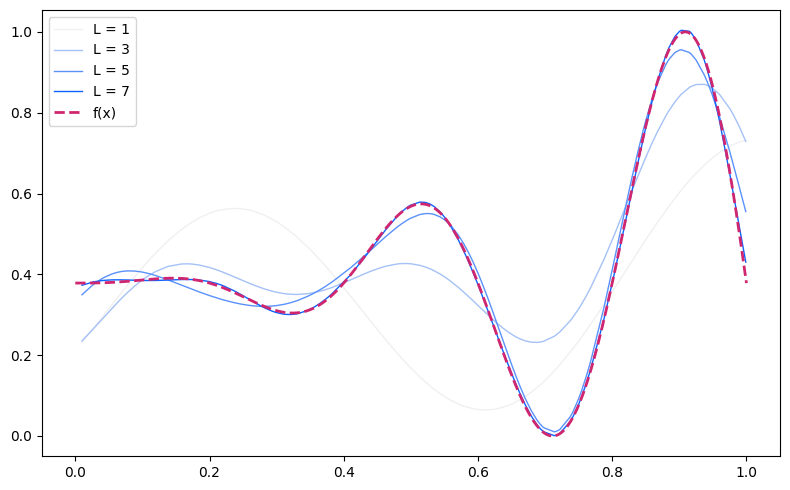

In [8]:
with open("results.pkl", "rb") as f:
    results = pkl.load(f)

colors = sns.color_palette("light:#0f62fe", n_colors = 4)

plt.figure(figsize = (8, 5))

for (l, r), color in zip(results.items(), colors):
    plt.plot(X_test, r["y_predicted"], label = f"L = {l}", linewidth = 1, color = color)

plt.plot(X, y, color = "#d02670", linewidth = 2, linestyle = '--', label = "f(x)")

plt.legend()
plt.tight_layout()
plt.savefig("images/results.jpg", dpi = 800)
plt.show()

#### Curvas de entrenamiento

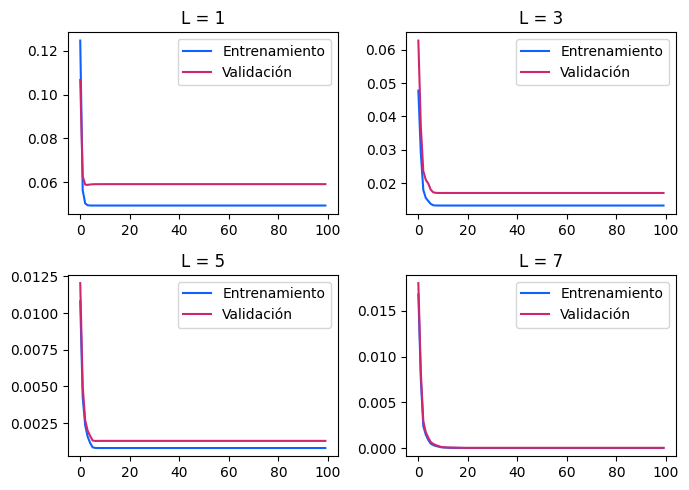

In [9]:
fig, axs = plt.subplots(2, 2, figsize = (7, 5))
for a, (l, r) in zip(axs.flatten(), results.items()):
    a.set_title(f"L = {l}")
    a.plot(r["train_losses"], color = "#0f62fe", label = "Entrenamiento")
    a.plot(r["val_losses"], color = "#d02670", label = "Validación")
    a.legend()
    

plt.tight_layout()
plt.savefig("images/losses.jpg", dpi = 800)
plt.show()

#### Tablas de resultados

In [29]:
df = pd.DataFrame(results).T
df["val_loss"] = df.val_losses.apply(lambda x: x[-1])
df.train_time = df.train_time.apply(lambda x: f"{int(x // 60)}' {int(x % 60)}''")
print(df[["val_loss", "train_time"]].to_latex())

\begin{tabular}{lrl}
\toprule
 & val_loss & train_time \\
\midrule
1 & 0.059030 & 0' 44'' \\
3 & 0.017047 & 2' 41'' \\
5 & 0.001293 & 4' 13'' \\
7 & 0.000046 & 11' 6'' \\
\bottomrule
\end{tabular}

